In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from bams.bayes_adaptor import BayesAdaptor 
from bams.adaptive_tools import *

# Generating statistically independent histogram counts
`BAMS` requires statistically independent state counts in order to perform reliable inference. This notebook generates these independent histogram counts using `np.random.multinomial`.

## Adaptive estimate for 5 state system  

#### Hyperparameters

In [2]:
prior = 'gaussian'    # Choice is between 'gaussian' and 'cauchy'
spread = 100.0      # (Half the interquartile range in the cauchy function)
location = 0.0

# The zeta sampling scheme
method = 'thompson'  # Use the MAP estimate of the free energy to select the next biasing potential
logistic = False

# Number of mixture samples per iteration
nsamps = 1

# Emcee parameters for sampling from the posterior distribution of free energies
nmoves = 200
nwalkers = 20
burnin = 70

**Generating the targets**

In [3]:
# Generating the target free energy from the prior
f_true = -np.random.uniform(-200,200,size=4)
p = np.hstack((1, np.exp(-f_true)))
p = p / np.sum(p)
print('Target:', np.hstack((0,f_true)))
print('probs:', p)

Target: [   0.          -80.04618692    2.93084535  -48.73473186  183.32150753]
probs: [  1.72338664e-035   1.00000000e+000   9.19459826e-037   2.52120318e-014
   4.17699145e-115]


In [4]:
# The initial biasing potential is drawn from the prior
#zetas = [np.hstack((0.0, gen_free_energy(prior, spread, location, size=4)))]
zetas = [np.repeat(0,5)]
counts = []

# Pre-assigment for data collection
map_estimate = []
median = []
lowerq = []
upperq = []
ncycles = 25
for i in range(ncycles):
    # Sample from multinomial
    q = p*np.exp(zetas[-1])
    q = q / np.sum(q)
    counts.append(np.random.multinomial(nsamps,q))
    # Reset the apdaptor
    adaptor = BayesAdaptor(zetas=np.array(zetas), counts=np.array(counts), prior=prior, method=method, spread=spread, location=location)
    # Sample a new biasing potential
    zetas.append(adaptor.update(nwalkers=nwalkers, nmoves=nmoves))
    # Collect data
    map_estimate.append(adaptor.map_estimator())
    median.append(np.percentile(adaptor.flat_samples, 50, axis=0))
    upperq.append(np.percentile(adaptor.flat_samples, 97.5, axis=0))
    lowerq.append(np.percentile(adaptor.flat_samples, 2.5,axis=0))
map_estimate = np.array(map_estimate)
median = np.array(median)
lowerq = np.array(lowerq)
upperq = np.array(upperq)

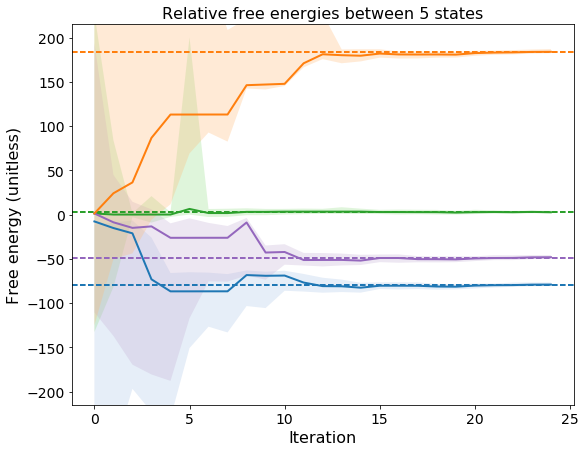

In [5]:
plt.clf()
plt.figure(figsize=(9,7))

x = np.arange(map_estimate.shape[0])
for i in range(4):
    plt.plot(x, map_estimate[:,i], color=tableau4[i], lw=2)
    plt.axhline(y = f_true[i], color=tableau4[i], ls='--', lw=2)
    plt.fill_between(x, lowerq[:,i], upperq[:,i], facecolor=tableau4_light[i], linewidth=0, alpha=0.3, interpolate=True)
plt.ylim((-215,215))
plt.title('Relative free energies between 5 states', fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Free energy (unitless)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

The full lines represent the free energy estimates as a function of the `BAMS` iteration, and the dotted lines indicate the target free energies. As can be seen, convergence of the estimates is swift when the counts are independent, and the 95 percent credible regions appear to encompass the target at all iterations. 